# TELL Runs for IM3's Experiment Group B 

This notebook executes the initial set of runs of the TELL model for IM3's Experiment Group B.

In [1]:
# Start by importing the TELL package and information about your operating system:
import os 
import tell

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tell.package_data import get_ba_abbreviations


## Set the Directory Structure

In [2]:
# Identify the top-level directory and the subdirectory where the data will be stored:
current_dir =  '/Users/burl878/Documents/Research/IMMM/Data/TELL/Production_Runs'
tell_data_dir = os.path.join(current_dir, r'tell_data')

# If the "tell_data_dir" subdirectory doesn't exist then create it:
if not os.path.exists(tell_data_dir):
   os.makedirs(tell_data_dir)


## Run the MLP Models

In [ ]:
# Generate a list of BA abbreviations to process:
ba_abbrev_list = tell.get_balancing_authority_to_model_dict().keys()

scenario_to_process = 'rcp85hotter_ssp5'

# Run the MLP prediction step for the list of BAs using parallel processing streams:
for year_to_process in range(2020,2100,1):
    pdf = tell.predict_batch(target_region_list = ba_abbrev_list,
                             year = year_to_process,
                             data_dir = os.path.join(tell_data_dir, r'wrf_to_tell_data', scenario_to_process),
                             datetime_field_name = 'Time_UTC',
                             save_prediction = True,
                             prediction_output_directory = os.path.join(tell_data_dir, r'outputs', r'mlp_output', scenario_to_process),
                             n_jobs = -1)


## Run the Forward Execution

In [ ]:
# Run the TELL model forward in time for a given year in five year increments out to 2100:
for year in range(2090,2100,1):
    summary_df, ba_time_series_df, state_time_series_df = tell.execute_forward(year_to_process = str(year),
                                                                               gcam_target_year = '2095', 
                                                                               scenario_to_process = 'rcp85hotter_ssp5',
                                                                               data_output_dir = '/Users/burl878/Documents/Research/IMMM/Data/TELL/Production_Runs/tell_data/outputs/tell_output',
                                                                               gcam_usa_input_dir = '/Users/burl878/Documents/Research/IMMM/Data/TELL/Production_Runs/tell_data/gcamusa_data',
                                                                               map_input_dir = '/Users/burl878/Documents/Research/IMMM/Data/TELL/Production_Runs/tell_data/ba_service_territory_data',
                                                                               mlp_input_dir = '/Users/burl878/Documents/Research/IMMM/Data/TELL/Production_Runs/tell_data/outputs/mlp_output',
                                                                               pop_input_dir = '/Users/burl878/Documents/Research/IMMM/Data/TELL/Production_Runs/tell_data/population_data',
                                                                               save_county_data = False)


## Visualize the Output

In [3]:
# Define a function to plot the interannual variability for a given BA or state:
def plot_load_duration_curve_variability(plot_ba, entity_to_plot: str, top_x_hours: int, scenario_to_plot: str, data_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    """Plot the interannual variability of the load duration curve for a given BA or state

    :param plot_ba:             Set to True if you want to plot the output for BAs
    :type plot_ba:              bool

    :param entity_to_plot:      BA code or state abbreviation for entity you want to plot
    :type entity_to_plot:       str

    :param top_x_hours:         Number of peak hours to be included in the load duration curve plot
    :type top_x_hours:          int

    :param scenario_to_plot:    Scenario you want to plot
    :type scenario_to_plot:     str

    :param data_input_dir:      Top-level data directory for TELL
    :type data_input_dir:       str

    :param image_output_dir:    Directory to store the images
    :type image_output_dir:     str

    :param image_resolution:    Resolution at which you want to save the images in DPI
    :type image_resolution:     int

    :param save_images:         Set to True if you want to save the images after they're generated
    :type save_images:          bool

    """

    # Set the data input directory:
    tell_data_input_dir = os.path.join(data_input_dir, r'outputs', r'tell_output', scenario_to_plot)

    # Set the image output directory:
    image_dir = os.path.join(image_output_dir, scenario_to_plot)

    # If the output directory doesn't exist then create it:
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    
    # Make the plot:
    plt.figure(figsize=(25, 10))
        
    for base_year in range(2025,2105,10):
        if plot_ba:
           for year_delta in range(-5,5,1):
               # Read in the 'TELL_Balancing_Authority_Hourly_Load_Data_' .csv file and parse the time variable:
               hourly_load_df = pd.read_csv((tell_data_input_dir + '/' + str(base_year) + '/' + 'TELL_Balancing_Authority_Hourly_Load_Data_' + str(base_year + year_delta) + '_Scaled_' + str(base_year) + '.csv'), parse_dates=["Time_UTC"])

               # Subset the dataframe to only the BA you want to plot:
               subset_df = hourly_load_df.loc[hourly_load_df['BA_Code'] == entity_to_plot]

               # Sort the hourly load values from largest to smallest and compute the hourly duration for each value:
               load_df_sorted_df = subset_df.sort_values(by=['Scaled_TELL_BA_Load_MWh'], ascending=False)
               load_df_sorted_df['Year'] = str(base_year + year_delta)
               load_df_sorted_df['Interval'] = 1
               load_df_sorted_df['Duration'] = load_df_sorted_df['Interval'].cumsum()
                  
               # Rename the load variable:
               load_df_sorted_df.rename(columns={'Scaled_TELL_BA_Load_MWh': 'Load_MWh'}, inplace=True)
            
               # Subset and reorder the columns:
               output_df = load_df_sorted_df[['Year', 'Duration', 'Load_MWh']]
        
               # Aggregate the output into a new dataframe:
               if year_delta == -5:
                  aggregate_output_df = output_df
               else:
                  aggregate_output_df = pd.concat([aggregate_output_df, output_df])

           aggregate_output_df = aggregate_output_df.loc[aggregate_output_df['Duration'] <= top_x_hours]
        
           if base_year == 2025:
              index = 1
           else:
              index = int(((base_year - 2025)/10) + 1)
        
           plt.subplot(2,4,index)
           for year_delta in range(-5,6,1):
               plt.plot(aggregate_output_df['Duration'].loc[aggregate_output_df['Year'] == str(base_year + year_delta)], 
                        aggregate_output_df['Load_MWh'].loc[aggregate_output_df['Year'] == str(base_year + year_delta)], 
                        color='gray', linestyle='-', label=('Load: ' + str(base_year + year_delta)), linewidth=1)
           plt.plot(aggregate_output_df['Duration'].loc[aggregate_output_df['Year'] == str(base_year)], aggregate_output_df['Load_MWh'].loc[aggregate_output_df['Year'] == str(base_year)],
                    color='black', linestyle='-', label='Base Year Load', linewidth=4)
           plt.xlim((0,top_x_hours))
           plt.xlabel("Duration [h]")
           plt.ylabel("Hourly Load [MWh]")
           plt.title((entity_to_plot + ' LDCs in ' + str(base_year) + ': ' + scenario_to_plot))
        
        if plot_ba == False:
           for year_delta in range(-5,5,1):
               # Read in the 'TELL_State_Summary_Data' .csv file and parse the time variable:
               hourly_load_df = pd.read_csv((tell_data_input_dir + '/' + str(base_year) + '/' + 'TELL_State_Hourly_Load_Data_' + str(base_year + year_delta) + '_Scaled_' + str(base_year) + '.csv'), parse_dates=["Time_UTC"])

               # Subset the dataframe to only the state you want to plot:
               subset_df = hourly_load_df.loc[hourly_load_df['State_Name'] == entity_to_plot]

               # Sort the hourly load values from largest to smallest and compute the hourly duration for each value:
               load_df_sorted_df = subset_df.sort_values(by=['Scaled_TELL_State_Load_MWh'], ascending=False)
               load_df_sorted_df['Year'] = str(base_year + year_delta)
               load_df_sorted_df['Interval'] = 1
               load_df_sorted_df['Duration'] = load_df_sorted_df['Interval'].cumsum()
                  
               # Rename the load variable:
               load_df_sorted_df.rename(columns={'Scaled_TELL_State_Load_MWh': 'Load_MWh'}, inplace=True)
            
               # Subset and reorder the columns:
               output_df = load_df_sorted_df[['Year', 'Duration', 'Load_MWh']]
        
               # Aggregate the output into a new dataframe:
               if year_delta == -5:
                  aggregate_output_df = output_df
               else:
                  aggregate_output_df = pd.concat([aggregate_output_df, output_df])

           aggregate_output_df = aggregate_output_df.loc[aggregate_output_df['Duration'] <= top_x_hours]
        
           if base_year == 2025:
              index = 1
           else:
              index = int(((base_year - 2025)/10) + 1)
        
           plt.subplot(2,4,index)
           for year_delta in range(-5,6,1):
               plt.plot(aggregate_output_df['Duration'].loc[aggregate_output_df['Year'] == str(base_year + year_delta)], 
                        aggregate_output_df['Load_MWh'].loc[aggregate_output_df['Year'] == str(base_year + year_delta)], 
                        color='gray', linestyle='-', label=('Load: ' + str(base_year + year_delta)), linewidth=1)
           plt.plot(aggregate_output_df['Duration'].loc[aggregate_output_df['Year'] == str(base_year)], aggregate_output_df['Load_MWh'].loc[aggregate_output_df['Year'] == str(base_year)],
                    color='black', linestyle='-', label='Base Year Load', linewidth=4)
           plt.xlim((0,top_x_hours))
           plt.xlabel("Duration [h]")
           plt.ylabel("Hourly Load [MWh]")
           plt.title((entity_to_plot + ' LDCs in ' + str(base_year) + ': ' + scenario_to_plot))

    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       if plot_ba:
          ba_name = entity_to_plot
          filename = ('TELL_BA_LDC_Variability_' + ba_name + '_' + scenario_to_plot + '.png')
          plt.savefig(os.path.join(image_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')   
       if plot_ba == False:
          state_name = entity_to_plot
          state_name = state_name.replace(" ", "_")
          filename = ('TELL_State_LDC_Variability_' + state_name + '_' + scenario_to_plot + '.png')
          plt.savefig(os.path.join(image_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')


In [7]:
# Get a list of BAs to process:
#ba_names = get_ba_abbreviations()
ba_names = ['CISO', 'PJM', 'ERCO', 'ISNE', 'MISO', 'AZPS']

# Loop over the list of BAs and make the LDC plot for each BA:
for i in ba_names:
    plot_load_duration_curve_variability(plot_ba = True,
                                         entity_to_plot = i, 
                                         top_x_hours = 168, 
                                         scenario_to_plot = 'rcp85hotter_ssp5', 
                                         data_input_dir = tell_data_dir,
                                         image_output_dir = '/Users/burl878/Documents/code_repos/tell/tell/production_visualizations', 
                                         image_resolution = 125, 
                                         save_images = True)
    plt.close()


In [8]:
# Get a list of states to process:
state_names = ['California', 'Texas', 'New York', 'Pennsylvania', 'Florida', 'Washington']

# Loop over the list of states and make the LDC plot for each state:
for i in state_names:
    plot_load_duration_curve_variability(plot_ba = False,
                                         entity_to_plot = i, 
                                         top_x_hours = 168, 
                                         scenario_to_plot = 'rcp85hotter_ssp5', 
                                         data_input_dir = tell_data_dir,
                                         image_output_dir = '/Users/burl878/Documents/code_repos/tell/tell/production_visualizations', 
                                         image_resolution = 125, 
                                         save_images = True)
    plt.close()


In [113]:
# Define a function to process the mean deviation for peak loads across BAs or states:
def process_peak_load_variability(process_bas,  top_x_hours: int, scenario_to_process: str, data_input_dir: str):
    """Process the interannual variability of peak loads across BAs or states:

    :param process_bas:         Set to True if you want to process the output for BAs
    :type process_bas:          bool

    :param top_x_hours:         Number of peak hours to be included in the analysis
    :type top_x_hours:          int

    :param scenario_to_process: Scenario you want to process
    :type scenario_to_process:  str

    :param data_input_dir:      Path to where the load output lives
    :type data_input_dir:       str

    """

    # Set the data input directory:
    tell_data_input_dir = os.path.join(data_input_dir, r'outputs', r'tell_output', scenario_to_process)

    # Set the output directory:
    output_dir = os.path.join(data_input_dir, r'outputs', r'postprocessed', scenario_to_process)

    # If the output directory doesn't exist then create it:
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Initiate an empty dataframe and counter to store the results:
    stats_df = pd.DataFrame()
    counter = -1;
    
    for base_year in range(2025,2100,10):
        if process_bas:
           for year_delta in range(-5,5,1):
               # Read in the 'TELL_Balancing_Authority_Hourly_Load_Data_' .csv file and parse the time variable:
               hourly_load_df = pd.read_csv((tell_data_input_dir + '/' + str(base_year) + '/' + 'TELL_Balancing_Authority_Hourly_Load_Data_' + str(base_year + year_delta) + '_Scaled_' + str(base_year) + '.csv'), parse_dates=["Time_UTC"])

               # Rename the load variable:
               hourly_load_df.rename(columns={'Scaled_TELL_BA_Load_MWh': 'Load_MWh'}, inplace=True)         
          
               # Make a list of all of the unique BAs in "hourly_load_df":
               unique_bas = hourly_load_df['BA_Code'].unique()
            
               # Loop over the BAs and process their top loads in the base year:
               for i in range(len(unique_bas)):
                   # Subset to just the data for the BA being processed:
                   subset_df = hourly_load_df[hourly_load_df['BA_Code'].isin([unique_bas[i]])].copy()
        
                   # Sort the hourly load values from largest to smallest and compute the hourly duration for each value:
                   load_df_sorted_df = subset_df.sort_values(by=['Load_MWh'], ascending=False)
                   load_df_sorted_df['Year'] = str(base_year + year_delta)
                   load_df_sorted_df['Target_Year'] = str(base_year)
                   load_df_sorted_df['Interval'] = 1
                   load_df_sorted_df['Duration'] = load_df_sorted_df['Interval'].cumsum()
               
                   # Subset to the top X hours:
                   load_df_sorted_df = load_df_sorted_df.loc[(load_df_sorted_df['Duration'] <= top_x_hours)]
                
                   # Subset and reorder the columns:
                   output_df = load_df_sorted_df[['BA_Code', 'Year', 'Target_Year', 'Duration', 'Load_MWh']]
                
                   # Aggregate the output into a new dataframe:
                   if (i == 0) and (year_delta == -5):
                      ba_output_df = output_df
                   else:
                      ba_output_df = pd.concat([ba_output_df, output_df])
          
           # Subset the dataframe the base year and the out years:
           base_year_df = ba_output_df.loc[ba_output_df['Year'] == str(base_year)].copy()
           out_year_df = ba_output_df.loc[ba_output_df['Year'] != str(base_year)].copy()
            
           # Rename the load variable in the base year dataframe:
           base_year_df.rename(columns={'Load_MWh': 'Base_Year_Load_MWh'}, inplace=True)
           
           # Merge the out year and base year dataframes together based on common BA_Code and Duration variables:
           merged_df = pd.merge(out_year_df, base_year_df, how='left', on=['BA_Code', 'Duration'])
        
           # Subset and reorder the columns:
           merged_df = merged_df[['BA_Code', 'Duration', 'Load_MWh', 'Base_Year_Load_MWh']]
            
           # Calculate the absolute and relative load difference:
           merged_df['Absolute_Load_Difference_MWh'] = abs(merged_df['Base_Year_Load_MWh'] - merged_df['Load_MWh']) 
           merged_df['Relative_Load_Difference_%'] = (merged_df['Absolute_Load_Difference_MWh'] / merged_df['Base_Year_Load_MWh']) * 100 
            
           # Make a list of all of the unique BAs in "hourly_load_df":
           unique_bas = merged_df['BA_Code'].unique()
            
           # Loop over the BAs and compute their mean relative bias:
           for i in range(len(unique_bas)):
               # Advance the counter by one:
               counter = counter + 1
                
               # Subset to just the data for the BA being processed:
               subset_df = merged_df[merged_df['BA_Code'].isin([unique_bas[i]])].copy()
               
               stats_df.loc[counter, 'Year'] = str(base_year)
               stats_df.loc[counter, 'BA_Code'] = unique_bas[i]
               stats_df.loc[counter, 'Absolute_Load_Difference_MWh'] = subset_df['Absolute_Load_Difference_MWh'].mean().round(2)
               stats_df.loc[counter, 'Relative_Load_Difference_%'] = subset_df['Relative_Load_Difference_%'].mean().round(2)
    
        if process_bas == False:
           for year_delta in range(-5,5,1):
               # Read in the 'TELL_State_Summary_Data' .csv file and parse the time variable:
               hourly_load_df = pd.read_csv((tell_data_input_dir + '/' + str(base_year) + '/' + 'TELL_State_Hourly_Load_Data_' + str(base_year + year_delta) + '_Scaled_' + str(base_year) + '.csv'), parse_dates=["Time_UTC"])
              
               # Rename the load variable:
               hourly_load_df.rename(columns={'Scaled_TELL_State_Load_MWh': 'Load_MWh'}, inplace=True)         
          
               # Make a list of all of the unique states in "hourly_load_df":
               unique_states = hourly_load_df['State_Name'].unique()
            
               # Loop over the states and process their top loads in the base year:
               for i in range(len(unique_states)):
                   # Subset to just the data for the state being processed:
                   subset_df = hourly_load_df[hourly_load_df['State_Name'].isin([unique_states[i]])].copy()
        
                   # Sort the hourly load values from largest to smallest and compute the hourly duration for each value:
                   load_df_sorted_df = subset_df.sort_values(by=['Load_MWh'], ascending=False)
                   load_df_sorted_df['Year'] = str(base_year + year_delta)
                   load_df_sorted_df['Target_Year'] = str(base_year)
                   load_df_sorted_df['Interval'] = 1
                   load_df_sorted_df['Duration'] = load_df_sorted_df['Interval'].cumsum()
               
                   # Subset to the top X hours:
                   load_df_sorted_df = load_df_sorted_df.loc[(load_df_sorted_df['Duration'] <= top_x_hours)]
                
                   # Subset and reorder the columns:
                   output_df = load_df_sorted_df[['State_Name', 'Year', 'Target_Year', 'Duration', 'Load_MWh']]
                
                   # Aggregate the output into a new dataframe:
                   if (i == 0) and (year_delta == -5):
                      state_output_df = output_df
                   else:
                      state_output_df = pd.concat([state_output_df, output_df])
          
           # Subset the dataframe the base year and the out years:
           base_year_df = state_output_df.loc[state_output_df['Year'] == str(base_year)].copy()
           out_year_df = state_output_df.loc[state_output_df['Year'] != str(base_year)].copy()
            
           # Rename the load variable in the base year dataframe:
           base_year_df.rename(columns={'Load_MWh': 'Base_Year_Load_MWh'}, inplace=True)
           
           # Merge the out year and base year dataframes together based on common State_Name and Duration variables:
           merged_df = pd.merge(out_year_df, base_year_df, how='left', on=['State_Name', 'Duration'])
        
           # Subset and reorder the columns:
           merged_df = merged_df[['State_Name', 'Duration', 'Load_MWh', 'Base_Year_Load_MWh']]
            
           # Calculate the absolute and relative load difference:
           merged_df['Absolute_Load_Difference_MWh'] = abs(merged_df['Base_Year_Load_MWh'] - merged_df['Load_MWh']) 
           merged_df['Relative_Load_Difference_%'] = (merged_df['Absolute_Load_Difference_MWh'] / merged_df['Base_Year_Load_MWh']) * 100 
            
           # Make a list of all of the unique states in "hourly_load_df":
           unique_states = hourly_load_df['State_Name'].unique()
            
           # Loop over the states and compute their mean relative bias:
           for i in range(len(unique_states)):
               # Advance the counter by one:
               counter = counter + 1
                
               # Subset to just the data for the BA being processed:
               subset_df = merged_df[merged_df['State_Name'].isin([unique_states[i]])].copy()
               
               stats_df.loc[counter, 'Year'] = str(base_year)
               stats_df.loc[counter, 'State_Name'] = unique_states[i]
               stats_df.loc[counter, 'Absolute_Load_Difference_MWh'] = subset_df['Absolute_Load_Difference_MWh'].mean().round(2)
               stats_df.loc[counter, 'Relative_Load_Difference_%'] = subset_df['Relative_Load_Difference_%'].mean().round(2)
              
    if process_bas:
       csv_output_filename = os.path.join(output_dir + '/BA_Peak_Load_Variability_Top_' + str(top_x_hours) + '_Hours.csv')
    if process_bas == False:
       csv_output_filename = os.path.join(output_dir + '/State_Peak_Load_Variability_Top_' + str(top_x_hours) + '_Hours.csv')
    
    # Write out the dataframe to a .csv file:
    stats_df.to_csv(csv_output_filename, sep=',', index=False)
    
    return stats_df
           

In [114]:
ba_stats_df = process_peak_load_variability(process_bas = True,
                                            top_x_hours = 168, 
                                            scenario_to_process = 'rcp85hotter_ssp5', 
                                            data_input_dir = tell_data_dir)

ba_stats_df

states_stats_df = process_peak_load_variability(process_bas = False,
                                                top_x_hours = 168, 
                                                scenario_to_process = 'rcp85hotter_ssp5', 
                                                data_input_dir = tell_data_dir)

states_stats_df

,Year,State_Name,Absolute_Load_Difference_MWh,Relative_Load_Difference_%
0,2025,Alabama,671.17,3.64
1,2025,Arizona,572.24,2.76
2,2025,Arkansas,296.38,3.52
3,2025,California,1486.02,2.35
4,2025,Colorado,136.99,1.24
...,...,...,...,...
387,2095,Virginia,1137.94,2.13
388,2095,Washington,404.09,1.04
389,2095,West Virginia,259.87,2.14
390,2095,Wisconsin,367.19,1.19


In [74]:
# Define a function to plot the mean deviation for peak loads across BAs or states:
def plot_peak_load_variability(plot_bas, top_x_hours: int, scenario_to_plot: str, data_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    """Plot the interannual variability of mean deviation for peak loads across BAs or states:

    :param plot_bas:            Set to True if you want to plot the output for BAs
    :type plot_bas:             bool

    :param top_x_hours:         Number of peak hours to be included in the analysis
    :type top_x_hours:          int

    :param scenario_to_plot:    Scenario you want to plot
    :type scenario_to_plot:     str

    :param data_input_dir:      Top-level data directory for TELL
    :type data_input_dir:       str

    :param image_output_dir:    Directory to store the images
    :type image_output_dir:     str

    :param image_resolution:    Resolution at which you want to save the images in DPI
    :type image_resolution:     int

    :param save_images:         Set to True if you want to save the images after they're generated
    :type save_images:          bool

    """

    # Set the data input directory:
    tell_data_input_dir = os.path.join(data_input_dir, r'outputs', r'postprocessed', scenario_to_plot)

    # Set the image output directory:
    image_dir = os.path.join(image_output_dir, scenario_to_plot)

    # If the output directory doesn't exist then create it:
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    
    # Read in the output file created by the "process_peak_load_variability" function:
    if plot_bas:
       df = pd.read_csv(tell_data_input_dir + '/BA_Peak_Load_Variability_Top_' + str(top_x_hours) + '_Hours.csv')
    if plot_bas == False:
       df = pd.read_csv(tell_data_input_dir + '/State_Peak_Load_Variability_Top_' + str(top_x_hours) + '_Hours.csv')
    
    # Make the plot:
    fig, axes = plt.subplots(2,1,figsize=(25, 10), sharex=True, sharey=False)
    a = df.boxplot(column=['Absolute_Load_Difference_MWh'], by=['Year'], ax=axes.flatten()[0])
    if plot_bas:
       a.set_title(('Load Difference Across Balancing Authorities For Top ' + str(top_x_hours) + ' Hours: ' + scenario_to_plot))
    if plot_bas == False:
       a.set_title(('Load Difference Across States For Top ' + str(top_x_hours) + ' Hours: ' + scenario_to_plot))
    a.set_xlabel('Year')
    a.set_ylabel('Mean Absolute Load Difference [MWh]')
    
    b = df.boxplot(column=['Relative_Load_Difference_%'], by=['Year'], ax=axes.flatten()[1])
    if plot_bas:
       b.set_title(('Relative Load Difference Across Balancing Authorities For Top ' + str(top_x_hours) + ' Hours: ' + scenario_to_plot))
    if plot_bas == False:
       b.set_title(('Relative Load Difference Across States For Top ' + str(top_x_hours) + ' Hours: ' + scenario_to_plot))
    b.set_xlabel('Year')
    b.set_ylabel('Mean Relative Load Difference [%]')
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
        if plot_bas:
           filename = ('Peak_Load_Variability_BAs_Top_' + str(top_x_hours) + '_' + scenario_to_plot + '.png')
        if plot_bas == False:
           filename = ('Peak_Load_Variability_States_Top_' + str(top_x_hours) + '_' + scenario_to_plot + '.png')
        plt.savefig(os.path.join(image_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')


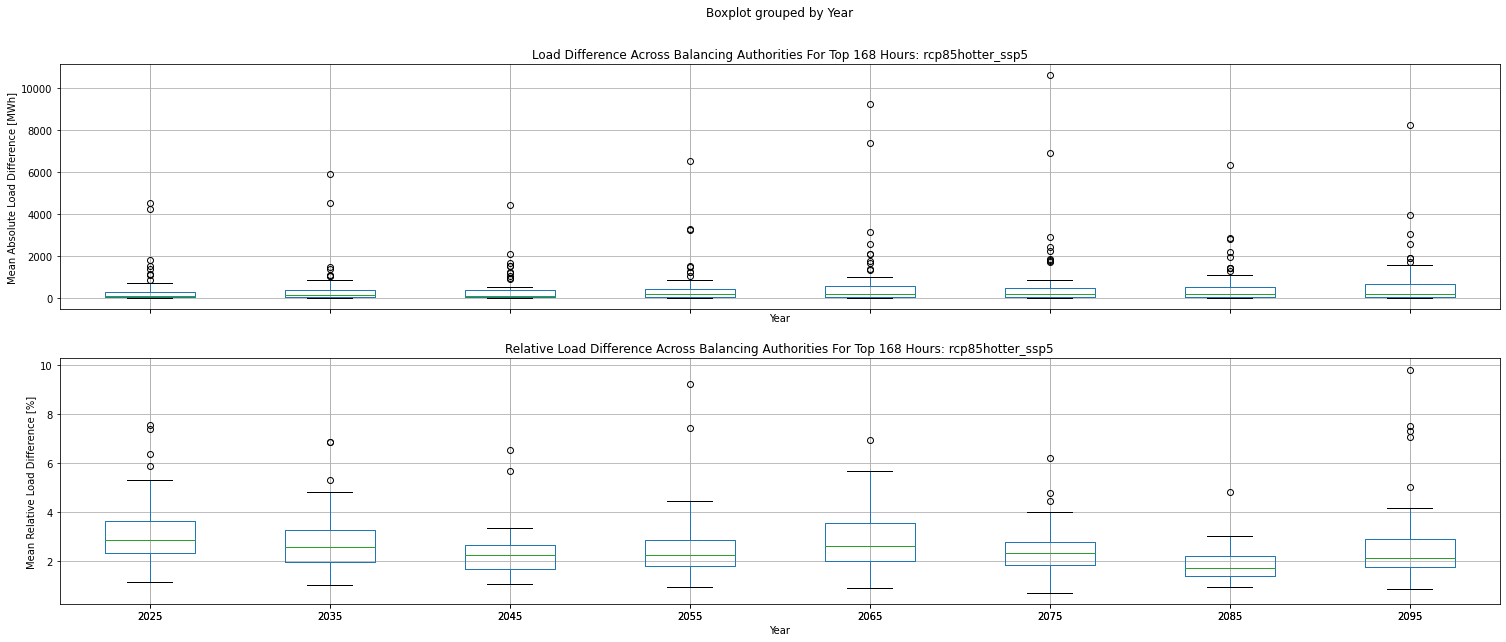

In [76]:
plot_peak_load_variability(plot_bas = True,
                           top_x_hours = 168, 
                           scenario_to_plot = 'rcp85hotter_ssp5', 
                           data_input_dir = tell_data_dir,
                           image_output_dir = '/Users/burl878/Documents/code_repos/tell/tell/production_visualizations', 
                           image_resolution = 125, 
                           save_images = True)
